<div style="text-align:center;">
  <div style="color:blue; font-size:24pt;">
   The PhotoDissociation Region Toolbox
    </div><br><br>
    <div  style="font-size:18pt">
    Marc Pound &amp; Mark Wolfire <br>
        University of Maryland
    </div>
</div>


### A python toolkit for analyzing observations of PDRs from JWST, SOFIA, ALMA, Herschel, and many more
<br>
<div style="font-size:16pt;color:darkred">Thanks to our sponsors:  </div>

* NASA ADAP #80NSSC19K0573 https://dustem.astro.umd.edu
* SOFIA *FEEDBACK* Legacy Program SOF070077 https://feedback.astro.umd.edu
* JWST-ERS *PDRs4All* program ID 1288 https://pdrs4all.org
<br><br>
<div style="text-align:center;">
  <div style="color:gray; font-size:16pt;">
      <i>Reliable Astrophysics at Everyday Low, Low Prices!</i> &reg;
    </div></div>
 <hr>
 JWST Webbinar 12/06/2022

### Get the PDR Toolbox

pip install pdrtpy -U
### Download the example notebooks
git clone https://github.com/mpound/pdrtpy-nb.git

This notebook is in `notebooks/PDRToolboxDemo.ipynb`

### To Learn More
Visit our website https://dustem.astro.umd.edu

Full documentation at https://pdrtpy.readthedocs.io

Our AJ paper in press: https://arxiv.org/abs/2210.08062

In [1]:
# all the imports needed for this demo
from pdrtpy.measurement import Measurement
from pdrtpy.modelset import ModelSet
from pdrtpy.tool.lineratiofit import LineRatioFit
from pdrtpy.tool.h2excitation import H2ExcitationFit
from pdrtpy.plot.modelplot import ModelPlot
from pdrtpy.plot.excitationplot import ExcitationPlot
from pdrtpy.plot.lineratioplot import LineRatioPlot
import pdrtpy.pdrutils as utils
from astropy.nddata import StdDevUncertainty
import astropy.units as u
from astropy.table import Table
import numpy as np

/home/mpound/src/pdrtpy/pdrtpy/pbar.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


In [2]:
# check you have the right version.  It should be 2.3.0 or higher
import pdrtpy
pdrtpy.version()

'2.3.1b'

# Example 1:  Finding density and radiation field
This example shows use the PDRT Toolbox to determine the PDR radiation field $G_0$ and hydrogen nucleus volume density $n$ from your spectral line and far-infrared (FIR) continuum data into the PDR Toolbox.  The case is for single pointing observations.

### Step 1. Input your intensity observations ("Measurements")

In [3]:
myunit = "erg s-1 cm-2 sr-1" # default unit for value and error
m1 = Measurement(data=3.6E-4,uncertainty = StdDevUncertainty(1.2E-4),
                 identifier="OI_63",unit=myunit)
m2 = Measurement(data=1E-6,uncertainty = StdDevUncertainty([3E-7]),
                 identifier="CI_609",unit=myunit)
m3 = Measurement(data=26,uncertainty = StdDevUncertainty([5]),
                 identifier="CO_43",restfreq="461.04077 GHz", 
                 unit="K km/s")
m4 = Measurement(data=8E-5,uncertainty = StdDevUncertainty([8E-6]),
                 identifier="CII_158",unit=myunit)
a = [m1,m2,m3,m4]

### Step 2. Choose a set of models 
In this example, we choose Wolfire-Kaufman 2020 set of models with metallicity z=1. The models in this `ModelSet` are listed.  We also have KOSMA-Tau models available.
All models are stored as intensity or intensity ratio maps and cover \[C I\], \[C II\], \[O I\], $H_2$, CO and $^{13}$CO up to J=20, and more.  The PDR Toolbox calculates appropriate ratios from your intensity observations, propogating errors.

In [4]:
ms = ModelSet("wk2020",z=1)
ms.supported_ratios.show_in_notebook()


idx,title,ratio label
0,[O I] 63 $\mu$m / [C II] 158 $\mu$m,OI_63/CII_158
1,([O I] 63 $\mu$m + [C II] 158 $\mu$m) / I$_{FIR}$,OI_63+CII_158/FIR
2,([O I] 145 $\mu$m + [C II] 158 $\mu$m) / I$_{FIR}$,OI_145+CII_158/FIR
3,[O I] 145 $\mu$m / [O I] 63 $\mu$m,OI_145/OI_63
4,[C I] 370 $\mu$m / [C I] 609 $\mu$m,CI_370/CI_609
5,[C II] 158 $\mu$m / [C I] 609 $\mu$m,CII_158/CI_609
6,[C II] 158 $\mu$m / [O I] 145 $\mu$m,CII_158/OI_145
7,[C II] 158 $\mu$m / I$_{FIR}$,CII_158/FIR
8,[C II] 158 $\mu$m / CO(J=1-0),CII_158/CO_10
9,[C II] 158 $\mu$m / CO(J=2-1),CII_158/CO_21


### Step 3. Create the fitter and run it.
This example uses the default least-squares fitting; MCMC is also available.  The results are stored in member variables as `Measurements` and in an `lmfit.ModelResult` object.

In [5]:
p = LineRatioFit(ms,measurements=a) 
p.run()

/home/mpound/src/pdrtpy/pdrtpy/tool/lineratiofit.py:384: UserWarning: LineRatioFit: No beam parameters in Measurement headers, assuming they are all equal!
  self._check_compatibility()


Converting K km/s to erg / (cm2 s sr) using Factor = +1.004E-07 g / (cm K s2)
fitted 1 of 1 pixels
got 0 exceptions


In [6]:
p.fit_result[0]

## Step 5: Visualize the results
Create a plotter and feed it the LineRatioFit object.  Then you can call various methods to plot the fit.
Here are three examples:  
- Your observed ratios with errors on their matching models in $(n,G_0)$ space
- The reduced $\chi^2$ plot of the fit as a function of $(n,G_0)$
- An overlay of all your observed ratios with errors in the model $(n,G_0)$ space

Note we choose to plot radiation field in Habing units, but common alternatives Draine, Mathis, and cgs units are supported.

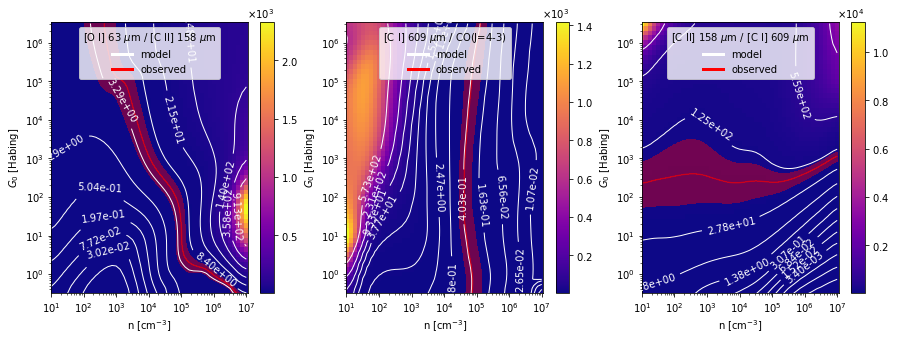

In [7]:
plot = LineRatioPlot(p)
plot.ratios_on_models(yaxis_unit="Habing",image=True,norm='simple',
                      ncols=3, cmap='plasma',
                       meas_color=['red'],label=True,colorbar=True)
# Save the figure to a PNG
plot.savefig("modelfits.png")

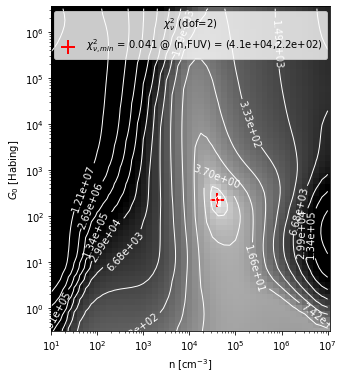

In [8]:
plot.reduced_chisq(cmap='gray_r',norm='log',label=True,
                   colors='white', legend=True,vmax=8E4,
                   yaxis_unit='Habing',
                   figsize=(5,7))

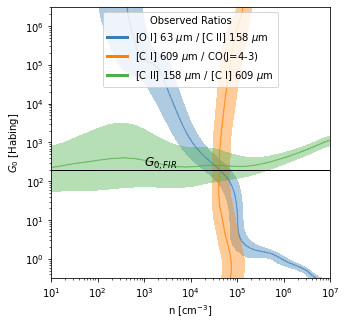

In [9]:
plot.overlay_all_ratios(yaxis_unit="Habing",figsize=(5,5))
# add a marker for G0 as determined from FIR observations
plot.text(1000,240,r"$G_{0,FIR}$",fontsize='large',color='k')
plot._plt.hlines(200,10,1E7,color='k',linewidth=1)

### You can also fit maps!
Here we use [C II], [O I], and FIR maps of the SMC molecular cloud N22 from [Jameson et al. 2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...853..111J/abstract) and a custom `ModelSet` for the SMC.

In [10]:
cii_meas = Measurement.read("../data/n22_cii_flux_error.fits", 
                            identifier="CII_158")
FIR_meas = Measurement.read("../data/n22_FIR_flux_error.fits", 
                            identifier="FIR")
oi_meas = Measurement.read("../data/n22_oi_flux_error.fits", 
                           identifier="OI_63")

smcmod = ModelSet("smc",z=0.1)
p = LineRatioFit(modelset=smcmod,
                 measurements=[cii_meas,FIR_meas,oi_meas])
p.run()

  0%|          | 0/11259 [00:00<?, ?it/s]

fitted 4768 of 11259 pixels
got 0 exceptions


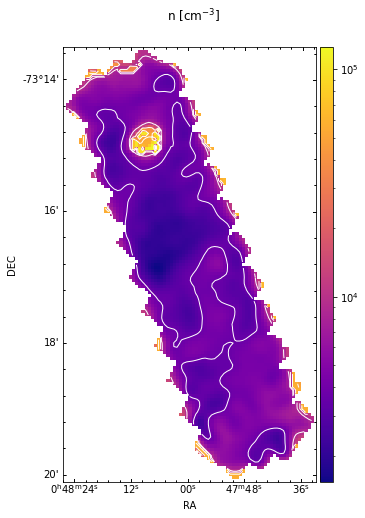

In [11]:
plot = LineRatioPlot(p)
plot.density(contours=True,norm="log",figsize=(5,8))


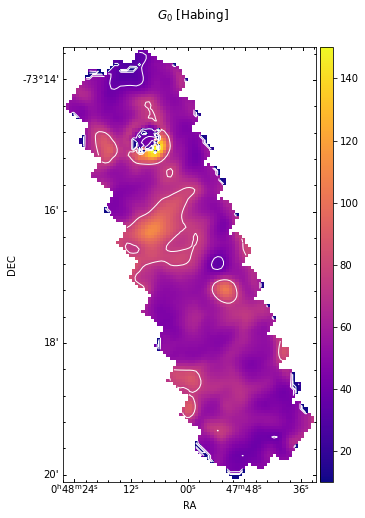

In [12]:
plot.radiation_field(units="Habing",contours=True,
                     norm="simple",figsize=(5,8))

# Example 2:  $H_2$ Excitation Diagrams
This example will go through the steps of computing the temperature and column density using $H_2$ line intensities plotted in an excitation diagram.  We will show fitting of an excitation diagram comprised of single pointing `Measurements`, both with fixed ortho-to-para ratio (OPR) and allowing OPR to vary. The data are from [Sheffer et al 2011](https://iopscience.iop.org/article/10.1088/0004-637X/741/1/45/pdf).

### As before, you input intensities as `Measurements`, instantiate a fitter, run it, and look at results.

In [13]:
intensity = dict()
intensity['H200S0'] = 3.003e-05
intensity['H200S1'] = 3.143e-04
intensity['H200S2'] = 3.706e-04
intensity['H200S3'] = 1.060e-03
intensity['H200S4'] = 5.282e-04
intensity['H200S5'] = 5.795e-04
a = []
for i in intensity:
    m = Measurement(data=intensity[i],
                    uncertainty=StdDevUncertainty(0.75*intensity[i]),
                    identifier=i,unit="erg cm-2 s-1 sr-1")
    a.append(m)

In [14]:
h = H2ExcitationFit(a)
h.run()
print('T(cold) = {:>8.2f}'.format(h.tcold))
print('T(hot) = {:>8.2f}'.format(h.thot))
print(f'N(cold) = {h.cold_colden:3.2E}')
print(f'N(hot) = {h.hot_colden:3.2E}')
print(f'N(total) = {h.total_colden:+.1e}')

fitted 1 of 1 pixels
got 0 exceptions and 0 bad fits
T(cold) =   123.77 +/-    88.69 K
T(hot) =   633.39 +/-    59.82 K
N(cold) = 5.64E+21 +/- 1.68E+22 1 / cm2
N(hot) = 2.25E+20 +/- 1.10E+20 1 / cm2
N(total) = +5.9e+21 +/- +1.7e+22 1 / cm2


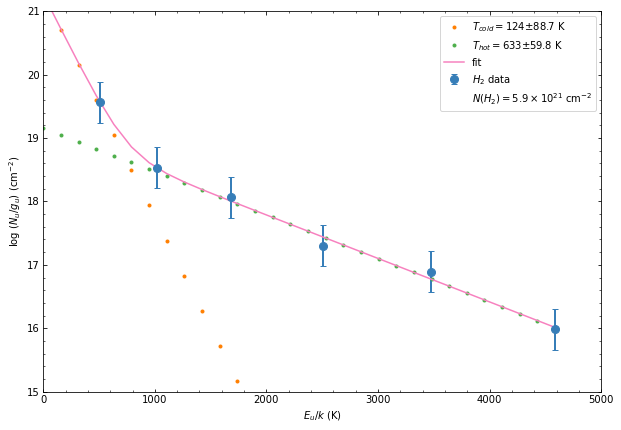

In [15]:
hplot = ExcitationPlot(h,"H_2")
hplot.ex_diagram(show_fit=True,ymax=21)

### The first fit looked ok, but we can do better by allowing the OPR to vary as well. 

fitted 1 of 1 pixels
got 0 exceptions and 0 bad fits


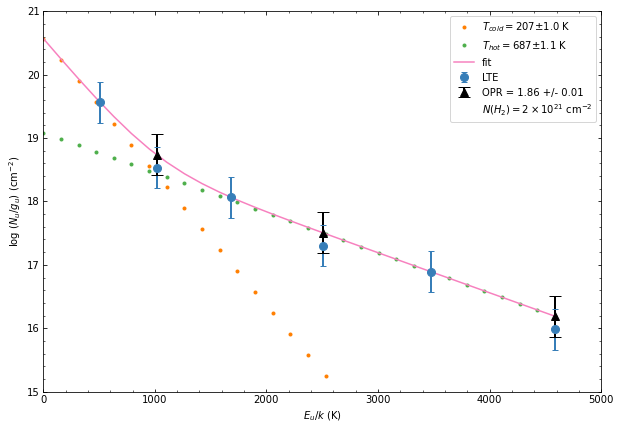

In [16]:
h.run(fit_opr=True)
hplot.ex_diagram(show_fit=True,ymax=21)

### You can also plot multiple vibrational levels.
This example uses Orion Bar data from [Kaplan et al 2021.](https://ui.adsabs.harvard.edu/abs/2021ApJ...919...27K/abstract)

In [17]:
# read in the Kaplan data and make Measurements from it
ktab = Table.read(utils.get_testdata("Kaplan+2021.tab"),format='ipac')
morion=[]
for d,un,i in zip(ktab["Forionbar"],ktab["e_Forionbar"],ktab["Line"]):
    if not np.ma.is_masked(d):
        morion.append(Measurement(d,uncertainty=StdDevUncertainty(un),
                              identifier=i,unit="erg s-1 cm-2 sr-1"))

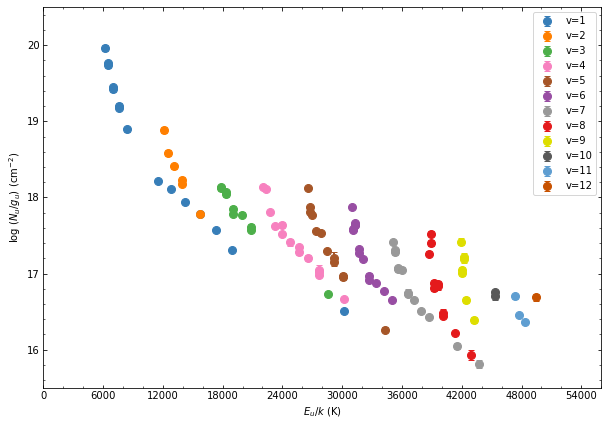

In [18]:
h = H2ExcitationFit(measurements=morion)
hplot = ExcitationPlot(h,"H_2")
# Give the parameter `label='v'` to show the vibrational levels
hplot.ex_diagram(ymin=15.5,ymax=20.5,label="v",xmax=56000)

# Example 3: Phase space and isocontour plots
As phase space plot shows ayn model ratio against any other model ratio (or model intensity) on which you can overlay observations.  In these examples we use the \[H II\] region diagnostic lines of Fe and Ar.  You create a `ModelPlot` with your chosen `ModelSet` and away you go!

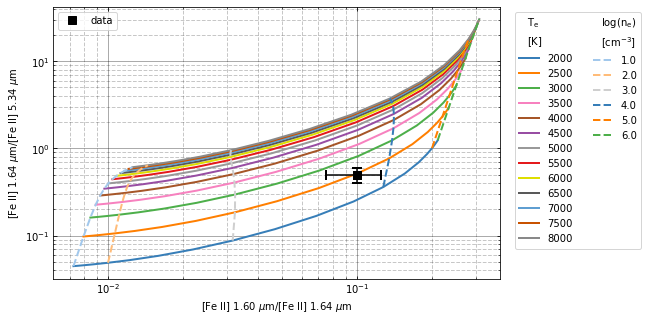

In [19]:
mp = ModelPlot(ms)
m1 = Measurement(data=[0.1],
                 uncertainty = StdDevUncertainty(0.025),
                 identifier="FEII_1.60/FEII_1.64",unit="")
m2 = Measurement(data=[0.5],
                 uncertainty = StdDevUncertainty(0.1),
                 identifier="FEII_1.64/FEII_5.34",unit="")
mp.phasespace(['FEII_1.60/FEII_1.64','FEII_1.64/FEII_5.34'],
              nax1_clip=[2E3,8E3]*u.Unit("K"),
              nax2_clip=[10,1E6]*u.Unit("cm-3"), 
              measurements=[m1,m2],errorbar=True)

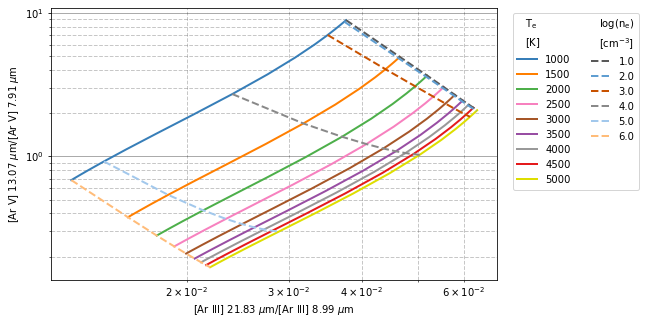

In [20]:
nax1clip = [1E3,5E3]*u.Unit("K")
nax2clip = [10,1E6]*u.Unit("cm-3")
mp.phasespace(["ARIII_21.83/ARIII_8.99","ARV_13.07/ARV_7.91"],
              nax1_clip=nax1clip,
              nax2_clip=nax2clip)

## You can make isocontour plots of individual model parameters
Related to the phase space plot is the `isoplot`, which will plot one of the model axes versus model value (intensity or intensity ratio) and draw on it iso-lines of the other model axis.

In the example below, we plot lines of constant electron gas temperature $T_e$ (isotherms) as a function of electron gas density $n_e$ and [Ar III] 21.83 $\mu$m / [Ar III] 8.99 $\mu$m intensity ratio. In our ionized gas models, $T_e$ is on FITS `NAXIS1` and $n_e$ is on `NAXIS2`.

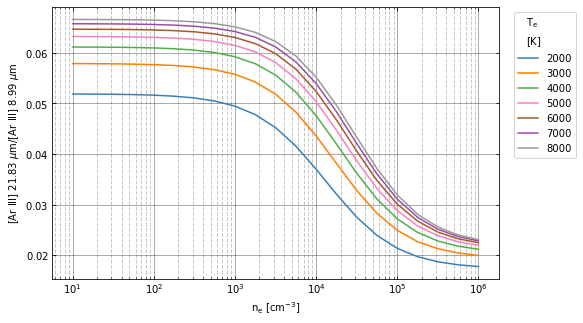

In [21]:
nax1clip = [2000,8000]*u.Unit("K")
# step=N means plot every N-th line in the given range.
# This helps avoid crowding on the plot.
mp.isoplot("ARIII_21.83/ARIII_8.99",
           plotnaxis=1,logx=True,
           nax_clip=nax1clip,step=2)

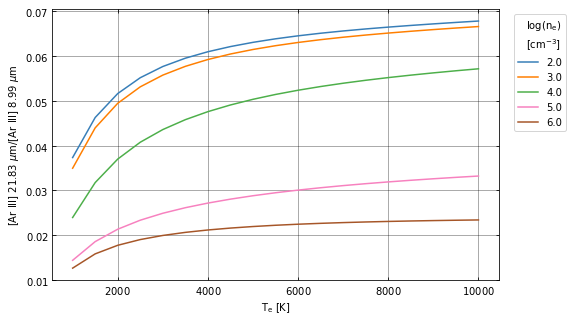

In [22]:
# Plotting the other model axis is easy, 
# just change plotnaxis and the clip values and units
nax1clip = [100,1E7]*u.Unit("cm-3")
mp.isoplot("ARIII_21.83/ARIII_8.99",
           plotnaxis=2,nax_clip=nax1clip,logx=False)

<div style="text-align:center;">
  <div style="color:blue; font-size:24pt;">
   There is much more the PDR Toolbox can do.
      <br>
We encourage you to download it and see for yourself!
    </div>
</div>
<br><br>

### We also welcome development. Fork us on github! https://github.com/mpound/pdrtpy

### Questions?


